# Task 4: House Price Prediction using Linear Regression

Building a regression model to predict house prices based on features such as house size, number of rooms, and location type.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Step 1: Load and Explore Dataset

### Load dataset

In [34]:
df = pd.read_csv("house_prices.csv")

### Inspect

In [35]:
print("Shape:", df.shape)
df.info()
df.describe()
df.head()

Shape: (2000, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Size             2000 non-null   int64 
 1   Location         2000 non-null   object
 2   Number of Rooms  2000 non-null   int64 
 3   Price            2000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 62.6+ KB


Size  Location  Number of Rooms   Price
0  1360  Downtown                5  149919
1  4272  Downtown                5  424998
2  3592  Downtown                2  266746
3   966  Suburban                4  244020
4  4926  Downtown                1  636056

## Step 2: Data Cleaning and Outlier Detection

### Check missing values

In [36]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 Size               0
Location           0
Number of Rooms    0
Price              0
dtype: int64


### Visualize distributions

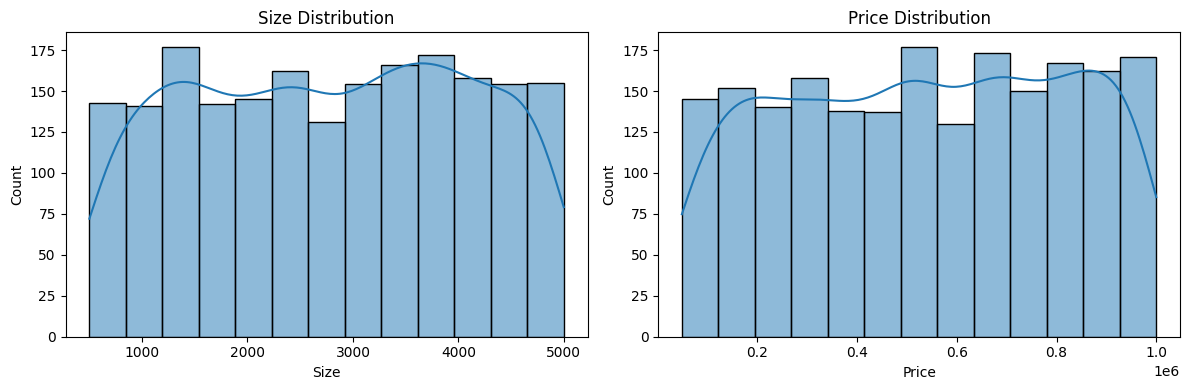

In [37]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['Size'], kde=True)
plt.title('Size Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['Price'], kde=True)
plt.title('Price Distribution')
plt.tight_layout()
plt.show()

### Boxplots to check for outliers

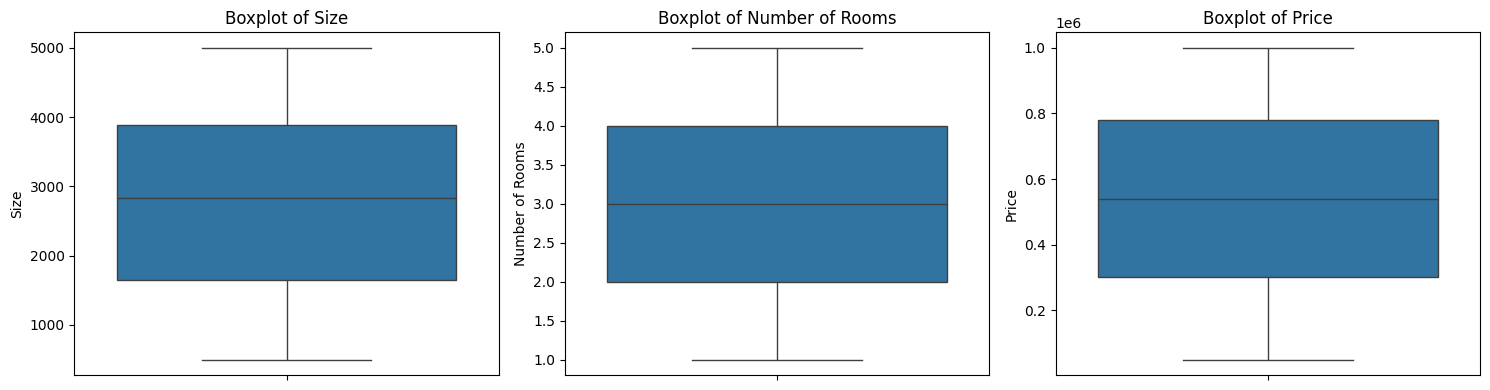

In [38]:
numeric_cols = ['Size', 'Number of Rooms', 'Price']

plt.figure(figsize=(15, 4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


### IQR Method to detect outliers

In [39]:
for col in ['Size', 'Number of Rooms', 'Price']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} outliers")


Size: 0 outliers
Number of Rooms: 0 outliers
Price: 0 outliers


## Step 3: Data Preprocessing

### Define features and target

In [40]:
X = df[['Size', 'Number of Rooms', 'Location']]
y = df['Price']

### Preprocessing pipeline

In [41]:
numerical_features = ['Size', 'Number of Rooms']
categorical_features = ['Location']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

## Step 4: Feature Selection

### Temporarily encode categorical data to calculate correlation

In [42]:
df_encoded = pd.get_dummies(df, drop_first=True)
corr = df_encoded.corr()

### Correlation heatmap

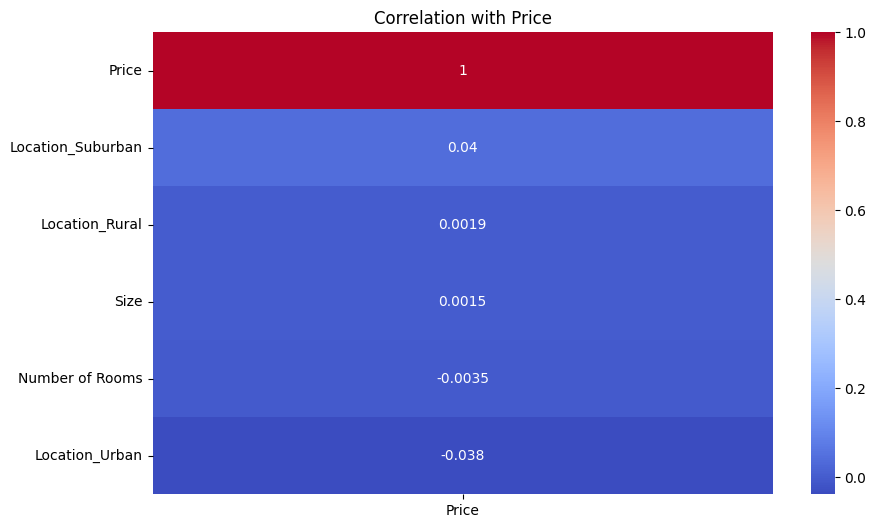

In [43]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr[['Price']].sort_values(by='Price', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation with Price')
plt.show()

> ⚠️ Note: The correlation heatmap does not show `Location_Downtown` because it was dropped during one-hot encoding (`drop_first=True`). This is done to prevent multicollinearity. All categorical effects are interpreted relative to `Downtown`, which acts as the base category.


## Step 5: Model Training

### Split data

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Create full pipeline

In [45]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

### Train model

In [46]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Size', 'Number of Rooms']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Location'])])),
                ('regressor', LinearRegression())])

## Step 6: Model Evaluation

### Predictions

In [47]:
y_pred = model.predict(X_test)

### RMSE and R² score

In [48]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", round(rmse, 2))
print("R² Score:", round(r2, 3))

Root Mean Squared Error (RMSE): 278152.9
R² Score: 0.006


## Step 7: Feature Insights

### Extract feature names

In [50]:
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
encoded_cols = ohe.get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(encoded_cols)

### Get coefficients

In [51]:
coefs = model.named_steps['regressor'].coef_

### Create DataFrame

In [52]:
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

coef_df

Feature   Coefficient
3  Location_Suburban  12056.466292
4     Location_Urban -11695.527286
2     Location_Rural   3008.514394
1    Number of Rooms    201.337706
0               Size   -171.235082

### Key Observations from the Regression Model:

- **Location** is the strongest influencer of house price:
  - **Suburban homes** are priced ~₹12,000 higher than Downtown (baseline).
  - **Urban homes** are priced ~₹11,700 lower than Downtown.
  - **Rural homes** have a small premium (~₹3,000) over Downtown, which may reflect dataset-specific trends.

- **Number of Rooms** has a small positive impact on price (₹201 per room), but the effect is limited, possibly due to overlapping impact with size.

- **Size** unexpectedly shows a **negative coefficient (−₹171)**, which suggests:
  - Possible **correlation with other features** (like rooms).
  - Potential **outliers** or **non-linear relationships** the linear model can't capture.
  - Size may have outliers or weak direct correlation with price in this dataset.
  - The negative coefficient reflects data-specific patterns, not necessarily real-world logic.
